In [1]:
import csv
import cv2
import numpy as np
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Flatten, Dense
from keras.layers import Conv2D, Lambda, MaxPooling2D, Dropout, Activation, Convolution2D, Cropping2D

Using TensorFlow backend.
/home/mengling/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Read all the training data

In [6]:
data = []
measurements = [] 
with open('/home/mengling/Desktop/train/driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        data.append(line)
        measurements.append(line[3])

In [21]:
measurements = [float(i) for i in measurements if i != 0]

(array([186.,  16.,  17.,  11.,  21.,  16.,   9.,  32.,  21.,  24.,  22.,
         19.,  31.,  20.,  22.,  36.,  21.,  47.,  21.,  42.,  27.,  32.,
         50.,  26.,  78.,  24.,  40.,  98.,  45.,  41., 121.,  64., 171.,
         75., 237.,  69.,  78., 345., 123., 404., 115., 115., 478., 111.,
        430., 111., 125., 451., 100., 123.,  72.,  71., 261.,  74., 283.,
         78.,  89., 275.,  88.,  72., 262.,  80., 240.,  68., 162.,  44.,
         63., 112.,  36., 118.,  42.,  24.,  67.,  30.,  30.,  56.,  20.,
         44.,  26.,  33.,  42.,  31.,  26.,  16.,  20.,  24.,  17.,  39.,
         17.,   4.,  34.,  18.,  25.,   7.,  11.,  18.,  12.,  25.,   7.,
        224.]),
 array([-1.  , -0.98, -0.96, -0.94, -0.92, -0.9 , -0.88, -0.86, -0.84,
        -0.82, -0.8 , -0.78, -0.76, -0.74, -0.72, -0.7 , -0.68, -0.66,
        -0.64, -0.62, -0.6 , -0.58, -0.56, -0.54, -0.52, -0.5 , -0.48,
        -0.46, -0.44, -0.42, -0.4 , -0.38, -0.36, -0.34, -0.32, -0.3 ,
        -0.28, -0.26, -0.24, -0.22

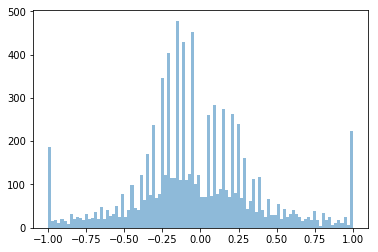

In [22]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
plt.hist(measurements, bins=100, alpha=0.5)

data[0]

In [ ]:
def train_generator(samples, batch_size=batch_size):
    num_samples = len(samples)
    while 1: # Loop forever so the generator never terminates
        from sklearn.utils import shuffle
        shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]

            images = []
            angles = []
            # Read center, left and right images from a folder containing Udacity data and my data
            for batch_sample in batch_samples:
                center_name = '/home/animesh/Documents/CarND/CarND-Behavioral-Cloning-P3/data2/IMG/'+batch_sample[0].split('/')[-1]
                center_image = cv2.imread(center_name)
                center_image = cv2.cvtColor(center_image, cv2.COLOR_BGR2RGB)
                left_name = '/home/animesh/Documents/CarND/CarND-Behavioral-Cloning-P3/data2/IMG/'+batch_sample[1].split('/')[-1]
                left_image = cv2.imread(left_name)
                left_image = cv2.cvtColor(left_image, cv2.COLOR_BGR2RGB)
                right_name = '/home/animesh/Documents/CarND/CarND-Behavioral-Cloning-P3/data2/IMG/'+batch_sample[2].split('/')[-1]
                right_image = cv2.imread(right_name)
                right_image = cv2.cvtColor(right_image, cv2.COLOR_BGR2RGB)

                center_angle = float(batch_sample[3])

                # Apply correction for left and right steering
                correction = 0.20
                left_angle = center_angle + correction
                right_angle = center_angle - correction

                # Randomly include either center, left or right image
                num = random.random()
                if num <= 0.33:
                    select_image = center_image
                    select_angle = center_angle
                    images.append(select_image)
                    angles.append(select_angle)
                elif num>0.33 and num<=0.66:
                    select_image = left_image
                    select_angle = left_angle
                    images.append(select_image)
                    angles.append(select_angle)
                else:
                    select_image = right_image
                    select_angle = right_angle
                    images.append(select_image)
                    angles.append(select_angle)

                # Randomly horizontally flip selected images with 80% probability
                keep_prob = random.random()
                if keep_prob >0.20:
                    flip_image = np.fliplr(select_image)
                    flip_angle = -1*select_angle
                    images.append(flip_image)
                    angles.append(flip_angle)

                # Augment with images of different brightness
                # Randomly select a percent change
                change_pct = random.uniform(0.4, 1.2)

                # Change to HSV to change the brightness V
                hsv = cv2.cvtColor(select_image, cv2.COLOR_RGB2HSV)

                hsv[:, :, 2] = hsv[:, :, 2] * change_pct
                # Convert back to RGB and append

                bright_img = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)
                images.append(bright_img)
                angles.append(select_angle)

                ## Randomly shear image with 80% probability
                shear_prob = random.random()
                if shear_prob >=0.20:
                    shear_range = 40
                    rows, cols, ch = select_image.shape
                    dx = np.random.randint(-shear_range, shear_range + 1)
                    #    print('dx',dx)
                    random_point = [cols / 2 + dx, rows / 2]
                    pts1 = np.float32([[0, rows], [cols, rows], [cols / 2, rows / 2]])
                    pts2 = np.float32([[0, rows], [cols, rows], random_point])
                    dsteering = dx / (rows / 2) * 360 / (2 * np.pi * 25.0) / 10.0
                    M = cv2.getAffineTransform(pts1, pts2)
                    shear_image = cv2.warpAffine(center_image, M, (cols, rows), borderMode=1)
                    shear_angle = select_angle + dsteering
                    images.append(shear_image)
                    angles.append(shear_angle)

            # trim image to only see section with road
            X_train = np.array(images)
            y_train = np.array(angles)

            yield shuffle(X_train, y_train)

In [ ]:
def data_generator(og_path, img_path, batch_size=batch_size):
    samples, images, measurements = [], [], []
    with open(log_path) as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        samples.append(line)
        
    num_samples = len(samples)

    while 1: # Loop forever so the generator never terminates
        from sklearn.utils import shuffle
        shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]
            # Read center, left and right images from a folder containing Udacity data and my data
            for batch_sample in batch_samples:
                for i in range(3):
                    source_path = batch_sample[i]
                    filename = source_path.split("/")[-1]
                    current_path = img_path + filename
                    image = cv2.imread(current_path)
                    images.append(image)
                    # center image
                    if i == 0: 
                        measurement = float(line[3])
                    # left image
                    elif i == 1:
                        measurement = float(line[3]) + 0.1
                    elif i == 2:
                        measurement = float(line[3]) - 0.1 
                    measurements.append(measurement)
            
                    

In [2]:
def read_data(log_path, img_path, augment=True):
    lines, images, measurements = [], [], []
    with open(log_path) as csvfile:
        reader = csv.reader(csvfile)
        for line in reader:
            lines.append(line)
    for line in lines:
        source_path = line[0]
        filename = source_path.split("/")[-1]
        current_path = img_path + filename
        image = cv2.imread(current_path)
        images.append(image)
        measurement = float(line[3])
        measurements.append(measurement)
    if augment:
        augmented_images, augmented_measurements = [], []
        for image, measurement in zip(images, measurements):
            augmented_images.append(image)
            augmented_measurements.append(measurement)
            augmented_images.append(cv2.flip(image, 1))
            augmented_measurements.append(measurement * -1.0)
        return augmented_images, augmented_measurements
    else:
        return images, measurements

In [ ]:
def read_data(log_path, img_path, augment=True):
    lines, images, measurements = [], [], []
    with open(log_path) as csvfile:
        reader = csv.reader(csvfile)
        for line in reader:
            lines.append(line)
    for line in lines:
        for i in range(3):
            source_path = line[i]
            filename = source_path.split("/")[-1]
            current_path = img_path + filename
            image = cv2.imread(current_path)
            images.append(image)
            # center image
            if i == 0: 
                measurement = float(line[3])
            # left image
            elif i == 1:
                measurement = float(line[3]) + 0.1
            elif i == 2:
                measurement = float(line[3]) - 0.1                
        measurements.append(measurement)
    if augment:
        augmented_images, augmented_measurements = [], []
        for image, measurement in zip(images, measurements):
            augmented_images.append(image)
            augmented_measurements.append(measurement)
            augmented_images.append(cv2.flip(image, 1))
            augmented_measurements.append(measurement * -1.0)
        return augmented_images, augmented_measurements
    else:
        return images, measurements

In [3]:
images1, measurements1 = read_data('/home/mengling/Desktop/train01/driving_log.csv', 
                                   '/home/mengling/Desktop/train01/IMG/', augment=True)
images2, measurements2 = read_data('/home/mengling/Desktop/train01b/driving_log.csv', 
                                   '/home/mengling/Desktop/train01b/IMG/', augment=True)
images3, measurements3 = read_data('/home/mengling/Desktop/train01c/driving_log.csv', 
                                   '/home/mengling/Desktop/train01c/IMG/', augment=True)
images4, measurements4 = read_data('/home/mengling/Desktop/train01d/driving_log.csv', 
                                   '/home/mengling/Desktop/train01d/IMG/', augment=True)
images5, measurements5 = read_data('/home/mengling/Desktop/train02/driving_log.csv', 
                                   '/home/mengling/Desktop/train02/IMG/', augment=True)

In [8]:
images = np.concatenate([images1, images2, images3, images4])
measurements = np.concatenate([measurements1, measurements2, measurements3, measurements4])
X_train = np.array(images)
y_train = np.array(measurements)

In [9]:
X_train.shape

(22194, 160, 320, 3)

## Build a Keras Model

In [10]:
model = Sequential()
model.add(Lambda(lambda x: x / 255.0 - 0.5, input_shape=(160,320,3)))
model.add(Cropping2D(cropping=((70, 25), (0,0))))
model.add(Convolution2D(24, 5, 5, subsample=(2, 2), activation='relu', dim_ordering="tf"))
model.add(Convolution2D(36, 5, 5, subsample=(2, 2), activation='relu', dim_ordering="tf"))
model.add(Dropout(p=0.7))
model.add(Convolution2D(48, 5, 5, subsample=(2, 2), activation='relu', dim_ordering="tf"))
model.add(Convolution2D(64, 3, 3, activation='relu', dim_ordering="tf"))
model.add(Convolution2D(64, 3, 3, activation='relu', dim_ordering="tf"))
model.add(Dropout(p=0.7))
model.add(Flatten())
model.add(Dense(100))
model.add(Dropout(p=0.7))
model.add(Dense(50))
model.add(Dense(10))
model.add(Dense(1))

## Compile and Train the model on training data, and save it as model.h5

In [11]:
model.compile(loss='mse', optimizer='adam')
model.fit(X_train, y_train, validation_split=0.2, shuffle=True)

model.save('/home/mengling/projects/carnd/Term1/CarND-Behavioral-Cloning-P3/model.h5')

Train on 17755 samples, validate on 4439 samples
Epoch 1/10
17755/17755 [==============================] - 17s - loss: 0.0190 - val_loss: 0.1032
Epoch 2/10
17755/17755 [==============================] - 17s - loss: 0.0182 - val_loss: 0.1040
Epoch 3/10
17755/17755 [==============================] - 16s - loss: 0.0182 - val_loss: 0.1033
Epoch 4/10
17755/17755 [==============================] - 16s - loss: 0.0181 - val_loss: 0.1032
Epoch 5/10
17755/17755 [==============================] - 16s - loss: 0.0181 - val_loss: 0.1035
Epoch 6/10
17755/17755 [==============================] - 16s - loss: 0.0181 - val_loss: 0.1032
Epoch 7/10
17755/17755 [==============================] - 16s - loss: 0.0181 - val_loss: 0.1032
Epoch 8/10
17755/17755 [==============================] - 16s - loss: 0.0181 - val_loss: 0.1032
Epoch 9/10
17755/17755 [==============================] - 16s - loss: 0.0181 - val_loss: 0.1032
Epoch 10/10
17755/17755 [==============================] - 16s - loss: 0.0181 - val_los